<a href="https://colab.research.google.com/github/ihatethinkingname/dl_practice/blob/main/sasrec_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

import copy
import math
import os

In [ ]:
# Transformer practice part

class EnD(nn.Module):
  def __init__(self,encoder,decoder,src_embed,tgt_embed,generator):
    super().__init__()
    self.encoder=encoder
    self.decoder=decoder
    self.src_embed=src_embed
    self.tgt_embed=tgt_embed
    self.generator=generator

  def forward(self,src,tgt,src_mask,tgt_mask):
    return self.decoder(self.encoder(src,src_mask),src_mask,tgt,tgt_mask)

  def encode(self,src,src_mask):
    return self.encoder(self.src_embed(src),src_mask)

  def decode(self,memory,src_mask,tgt,tgt_mask):
    return self.decoder(memory,src_mask,self.tgt_embed(tgt),tgt_mask)

class Embeddings(nn.Module):
  def __init__(self,vocab_size,d_model):
    super().__init__()
    self.lut=nn.Embedding(vocab_size,d_model,padding_idx=0)
    self.d_model=d_model

  def forward(self,x):
    return self.lut(x) * math.sqrt(self.d_model)

class PositionalEmbedding(nn.Module):
  def __init__(self,d_model,max_len=5000,dropout_rate=0.1):
    super().__init__()
    self.pos_embedding=nn.Embedding(max_len,d_model,padding_idx=0)
    self.dropout=nn.Dropout(dropout_rate)

  def forward(self,x,zero_padding=True):
    batch_size=x.shape[0]
    seq_len=x.shape[1]
    device=x.device
    pos_idx=torch.arange(0,seq_len,device=device).unsqueeze(0).expand(batch_size,seq_len)
    if zero_padding:
      pad_mask=x.abs().sum(dim=-1)!=0
      pos_idx=pos_idx*pad_mask.long()
    x = x + self.pos_embedding(pos_idx)
    return self.dropout(x)

class Generator(nn.Module):
  def __init__(self,d_model,vocab_size):
    super().__init__()
    self.proj=nn.Linear(d_model,vocab_size)

  def forward(self,x):
    return F.log_softmax(self.proj(x),dim=-1)


class EnDcoder(nn.Module):
  def __init__(self,layer,N):
    super().__init__()
    self.layers=clone(layer,N)
    self.norm=nn.LayerNorm(layer.d_model)

  def forward(self,x,src_mask,tgt=None,tgt_mask=None):
    for layer in self.layers:
      x=layer(x,src_mask,tgt,tgt_mask)
    return self.norm(x)

def clone(layer,N):
  return nn.ModuleList([copy.deepcopy(layer) for _ in range(N)])

class EnDcoderLayer(nn.Module):
  def __init__(self,self_attn,ffn,d_model,dropout_rate,src_attn=None):
    super().__init__()
    self.self_attn=self_attn
    self.ffn=ffn
    self.connector=clone(SublayerConnection(d_model,dropout_rate),2)
    self.d_model=d_model
    if src_attn is not None:
      self.src_attn=src_attn
      self.connector.append(SublayerConnection(d_model,dropout_rate))

  def forward(self,x,src_mask,tgt=None,tgt_mask=None):
    if isEncoder(tgt,tgt_mask):
      x=self.connector[0](x,lambda x: self.self_attn(x,x,x,src_mask))
    else:
      m=x         # m is memoery
      x=tgt        # We keep using x as the thing go through the network
      x=self.connector[0](x,lambda x: self.self_attn(x,x,x,tgt_mask))
      x=self.connector[1](x,lambda x: self.src_attn(x,m,m,src_mask))
    return self.connector[-1](x,self.ffn)

def isEncoder(tgt,tgt_mask):
    # Encoder model
    if tgt is None and tgt_mask is None:
      return True
    # Decoder model
    elif tgt is not None and tgt_mask is not None:
      return False
    # Wrong input
    else:
      raise ValueError("Encoder instance input error: "\
               "tgt and tgt_mask should be both None or both not None.")

class SublayerConnection(nn.Module):
  def __init__(self,d_model,dropout_rate):
    super().__init__()
    self.norm=nn.LayerNorm(d_model)
    self.dropout=nn.Dropout(dropout_rate)

  def forward(self,x,sublayer):
    return x+self.dropout(sublayer(self.norm(x)))

def attention(q,k,v,mask=None,dropout=None):
  d_k=q.shape[-1]
  scores=torch.matmul(q,k.transpose(-2,-1))/math.sqrt(d_k)
  if mask is not None:
    scores=scores.masked_fill(mask==0,-1e9)
  p_attn=F.softmax(scores,dim=-1)
  if dropout is not None:
    p_attn=dropout(p_attn)
  return torch.matmul(p_attn,v),p_attn

class MultiHeadedAttention(nn.Module):
  def __init__(self,n_head,d_model,dropout_rate=0.1):
    super().__init__()
    assert d_model%n_head==0
    self.d_head=d_model//n_head
    self.n_head=n_head
    self.linears=clone(nn.Linear(d_model,d_model),4)
    self.p_attn=None
    self.dropout=nn.Dropout(p=dropout_rate)

  def forward(self,query,key,value,mask=None):
    if mask is not None:
      mask=mask.unsqueeze(1)
    batch_size=query.shape[0]
    q,k,v=[l(x).view(batch_size,-1,self.n_head,self.d_head).transpose(1,2)
        for l,x in zip(self.linears,(query,key,value))]
    x,self.p_attn=attention(q,k,v,mask=mask,dropout=self.dropout)
    x=x.transpose(1,2).contiguous().view(batch_size,-1,self.n_head*self.d_head)
    return self.linears[-1](x)

class FFN(nn.Module):
  def __init__(self,d_model,d_ff,dropout_rate=0.1):
    super().__init__()
    self.L1=nn.Linear(d_model,d_ff)
    self.dropout=nn.Dropout(0.1)
    self.L2=nn.Linear(d_ff,d_model)

  def forward(self,x):
    return self.L2(self.dropout(F.relu(self.L1(x))))

def causal_mask(seq_len,device):
  # causal_mask=~torch.tril(torch.ones((seq_len,seq_len),dtype=torch.float,device=self.device))
  i=torch.arange(seq_len)
  return (i[:,None])>=(i[None,:]).to(device)

def make_model(src_vocab,tgt_vocab,d_model=512,n_sublayer=6,d_ff=2048,n_head=8,dropout_rate=0.1):
  c=copy.deepcopy

  src_embed=Embeddings(src_vocab,d_model)
  tgt_embed=Embeddings(tgt_vocab,d_model)
  generator=Generator(d_model,tgt_vocab)
  pos_embed=PositionalEmbedding(d_model)

  attn=MultiHeadedAttention(n_head,d_model,dropout_rate)
  ffn=FFN(d_model,d_ff,dropout_rate)
  encoder=EnDcoder(EnDcoderLayer(c(attn),c(ffn),d_model,dropout_rate),n_sublayer)
  decoder=EnDcoder(EnDcoderLayer(c(attn),c(ffn),d_model,dropout_rate,c(attn)),n_sublayer)

  model=EnD(encoder,decoder,nn.Sequential(c(src_embed),c(pos_embed)),
            nn.Sequential(c(tgt_embed),c(pos_embed)),generator)

  for p in model.parameters():
    if p.dim()>1:
      nn.init.xavier_uniform_(p)

  return model


In [ ]:
# SASRec practice part

class SASRec(nn.Module):
  def __init__(self,n_user,n_item,args):
    super().__init__()
    self.n_user=n_user
    self.n_item=n_item
    self.device=args.device
    d_model=args.d_model

    self.item_emb=Embeddings(n_item,d_model)
    self.pos_encode=PositionalEmbedding(d_model,args.max_len,args.dropout_rate)

    self.self_attn=MultiHeadedAttention(args.n_head,d_model,args.dropout_rate)
    self.ffn=FFN(d_model,args.d_ff,args.dropout_rate)
    self.encoder=EnDcoder(EnDcoderLayer(self.self_attn,self.ffn,d_model,args.dropout_rate),args.n_sublayer)


  def log2feat(self,log_seq):  # Is log_seq a tensor?
    if not torch.is_tensor(log_seq):
      log_seq = torch.as_tensor(log_seq)
    log_seq = log_seq.to(self.device, dtype=torch.long)
    pad_mask=(log_seq!=0).unsqueeze(1).unsqueeze(2)

    log_seq=self.pos_encode(self.item_emb(log_seq))

    seq_len=log_seq.shape[1]
    a_causal_mask=causal_mask(seq_len,self.device).unsqueeze(0).unsqueeze(1)
    combined_mask=pad_mask & a_causal_mask
    feat_seq=self.encoder(log_seq,combined_mask)

    return feat_seq

  def forward(self,log_seq,pos_seq,neg_seq):  # Are pos_seq and neg_seq float?
    feat_seq=self.log2feat(log_seq)

    if not torch.is_tensor(pos_seq):
        pos_seq = torch.as_tensor(pos_seq)
    if not torch.is_tensor(neg_seq):
        neg_seq = torch.as_tensor(neg_seq)
    pos_seq_embed=self.item_emb(pos_seq.to(dtype=torch.long, device=self.device))
    neg_seq_embed=self.item_emb(neg_seq.to(dtype=torch.long, device=self.device))

    pos_logits=(feat_seq*pos_seq_embed).sum(dim=-1)
    neg_logits=(feat_seq*neg_seq_embed).sum(dim=-1)

    return pos_logits,neg_logits

  def predict(self,log_seq,item_indices):
    feat_seq=self.log2feat(log_seq)[:,-1,:]

    if not torch.is_tensor(item_indices):
      item_indices = torch.as_tensor(item_indices)
    item_indices=item_indices.to(dtype=torch.long,device=self.device)

    item_embed=self.item_emb(item_indices)

    logits=item_embed.matmul(feat_seq.unsqueeze(-1)).squeeze(-1)

    return logits

In [ ]:
args=dict(
    d_model=32,
    n_head=2,
    d_ff=4*32,
    n_sublayer=2,
    dropout_rate=0.5,

    device='cuda:0',
    inference_only=False,
    n_epoch=4,
    batch_size=128,
    max_len=200,
    lr=1e-4,
    n_neg_sample=256,

    top_k=10
)

In [ ]:
import os
from collections import defaultdict
import random

def download_from_github(file_url, local_filename=None):
    if local_filename is None:
        local_filename = file_url.split('/')[-1]

    if os.path.exists(local_filename):
        print(f"文件已存在：{local_filename}，跳过下载")
    else:
        print(f"开始下载 {local_filename} ...")
        !wget -q {file_url}
        print(f"下载完成：{local_filename}")

def read_file(filepath='ml-1m.txt'):
    user_hist = defaultdict(list)
    with open(filepath, 'r') as f:
        for line in f:
            user, item = line.strip().split()
            user, item = int(user), int(item)
            user_hist[user].append(item)
    return user_hist

# Actually don't need this, since the data has processed
def create_item_mapping(user_hist):
    all_items = set()
    for items in user_hist.values():
        all_items.update(items)
    item2idx = {item: idx + 1 for idx, item in enumerate(all_items)}  # 0 用于 PAD
    idx2item = {idx: item for item, idx in item2idx.items()}
    return item2idx, idx2item

def sample_negative(n_item, pos_items, n_neg):
    negs = []
    for _ in range(n_neg):
      neg = random.randint(1, n_item)
      while neg in pos_items:
          neg = random.randint(1, n_item)
      negs.append(neg)
    return negs

def build_seq(max_len,user_hist,item2idx):
  for users,items in user_hist.items():
    item_idx=[item2idx[i] for i in items]
    for i in range(1,len(item_idx)):


开始下载 ml-1m.txt ...
下载完成：ml-1m.txt


In [ ]:
file_url = "https://raw.githubusercontent.com/pmixer/SASRec.pytorch/bdb6b77da98b9d6c395283d8b4e1a8bd7cb91efa/python/data/ml-1m.txt"
download_from_github(file_url)
user_hist=read_file()
# This dataset has processed in "User Item" form
# Build interaction sequence


missed u:
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [ ]:
import os
from torch.utils.data import Dataset
from collections import defaultdict



def build_index():
  user_item_form=np.loadtxt('ml-1m.txt',dtype=np.int32)
  n_user=user_item_form[:,0].max()
  n_item=user_item_form[:,1].max()

  u2i_index=[[] for _ in range(n_user+1)]
  i2u_index=[[] for _ in range(n_item+1)]

  for u_i in user_item_form:
    u2i_index[u_i[0]].append(u_i[1])
    i2u_index[u_i[1]].append(u_i[0])

  return u2i_index,i2u_index

class ml1mDataset(Dataset):
  def __init__(self,max_len=10,split='train'):
    self.max_len=max_len
    self.split=split
    self.User=defaultdict(list)



In [ ]:
import sys
import copy
import torch
import random
import numpy as np
from collections import defaultdict
from multiprocessing import Process, Queue

# sampler for batch generation
def random_neq(l, r, s):
    t = np.random.randint(l, r)
    while t in s:
        t = np.random.randint(l, r)
    return t


def sample_function(user_train, usernum, itemnum, batch_size, max_len, result_queue, SEED):
    def sample(uid):

        # uid = np.random.randint(1, usernum + 1)
        while len(user_train[uid]) <= 1: uid = np.random.randint(1, usernum + 1)

        seq = np.zeros([max_len], dtype=np.int32)
        pos = np.zeros([max_len], dtype=np.int32)
        neg = np.zeros([max_len], dtype=np.int32)
        nxt = user_train[uid][-1]
        idx = max_len - 1

        ts = set(user_train[uid])
        for i in reversed(user_train[uid][:-1]):
            seq[idx] = i
            pos[idx] = nxt
            if nxt != 0: neg[idx] = random_neq(1, itemnum + 1, ts)
            nxt = i
            idx -= 1
            if idx == -1: break

        return (uid, seq, pos, neg)

    np.random.seed(SEED)
    uids = np.arange(1, usernum+1, dtype=np.int32)
    counter = 0
    while True:
        if counter % usernum == 0:
            np.random.shuffle(uids)
        one_batch = []
        for i in range(batch_size):
            one_batch.append(sample(uids[counter % usernum]))
            counter += 1
        result_queue.put(zip(*one_batch))


class WarpSampler(object):
    def __init__(self, User, usernum, itemnum, batch_size=64, max_len=10, n_workers=1):
        self.result_queue = Queue(maxsize=n_workers * 10)
        self.processors = []
        for i in range(n_workers):
            self.processors.append(
                Process(target=sample_function, args=(User,
                                    usernum,
                                    itemnum,
                                    batch_size,
                                    max_len,
                                    self.result_queue,
                                    np.random.randint(2e9)
                                    )))
            self.processors[-1].daemon = True
            self.processors[-1].start()

    def next_batch(self):
        return self.result_queue.get()

    def close(self):
        for p in self.processors:
            p.terminate()
            p.join()


# train/val/test data generation
def data_partition(fname):
    usernum = 0
    itemnum = 0
    User = defaultdict(list)
    user_train = {}
    user_valid = {}
    user_test = {}
    # assume user/item index starting from 1
    f = open('%s.txt' % fname, 'r')
    for line in f:
        u, i = line.rstrip().split(' ')
        u = int(u)
        i = int(i)
        usernum = max(u, usernum)
        itemnum = max(i, itemnum)
        User[u].append(i)

    for user in User:
        nfeedback = len(User[user])
        if nfeedback < 3:
            user_train[user] = User[user]
            user_valid[user] = []
            user_test[user] = []
        else:
            user_train[user] = User[user][:-2]
            user_valid[user] = []
            user_valid[user].append(User[user][-2])
            user_test[user] = []
            user_test[user].append(User[user][-1])
    return [user_train, user_valid, user_test, usernum, itemnum]

# TODO: merge evaluate functions for test and val set
# evaluate on test set
def evaluate(model, dataset, args):
    [train, valid, test, usernum, itemnum] = copy.deepcopy(dataset)

    NDCG = 0.0
    HT = 0.0
    valid_user = 0.0

    if usernum>10000:
        users = random.sample(range(1, usernum + 1), 10000)
    else:
        users = range(1, usernum + 1)
    for u in users:

        if len(train[u]) < 1 or len(test[u]) < 1: continue

        seq = np.zeros([args.max_len], dtype=np.int32)
        idx = args.max_len - 1
        seq[idx] = valid[u][0]
        idx -= 1
        for i in reversed(train[u]):
            seq[idx] = i
            idx -= 1
            if idx == -1: break
        rated = set(train[u])
        rated.add(0)
        item_idx = [test[u][0]]
        for _ in range(100):
            t = np.random.randint(1, itemnum + 1)
            while t in rated: t = np.random.randint(1, itemnum + 1)
            item_idx.append(t)

        predictions = -model.predict(*[np.array(l) for l in [[u], [seq], item_idx]])
        predictions = predictions[0] # - for 1st argsort DESC

        rank = predictions.argsort().argsort()[0].item()

        valid_user += 1

        if rank < 10:
            NDCG += 1 / np.log2(rank + 2)
            HT += 1
        if valid_user % 100 == 0:
            print('.', end="")
            sys.stdout.flush()

    return NDCG / valid_user, HT / valid_user


# evaluate on val set
def evaluate_valid(model, dataset, args):
    [train, valid, test, usernum, itemnum] = copy.deepcopy(dataset)

    NDCG = 0.0
    valid_user = 0.0
    HT = 0.0
    if usernum>10000:
        users = random.sample(range(1, usernum + 1), 10000)
    else:
        users = range(1, usernum + 1)
    for u in users:
        if len(train[u]) < 1 or len(valid[u]) < 1: continue

        seq = np.zeros([args.max_len], dtype=np.int32)
        idx = args.max_len - 1
        for i in reversed(train[u]):
            seq[idx] = i
            idx -= 1
            if idx == -1: break

        rated = set(train[u])
        rated.add(0)
        item_idx = [valid[u][0]]
        for _ in range(100):
            t = np.random.randint(1, itemnum + 1)
            while t in rated: t = np.random.randint(1, itemnum + 1)
            item_idx.append(t)

        predictions = -model.predict(*[np.array(l) for l in [[u], [seq], item_idx]])
        predictions = predictions[0]

        rank = predictions.argsort().argsort()[0].item()

        valid_user += 1

        if rank < 10:
            NDCG += 1 / np.log2(rank + 2)
            HT += 1
        if valid_user % 100 == 0:
            print('.', end="")
            sys.stdout.flush()

    return NDCG / valid_user, HT / valid_user

In [ ]:
import os
import time
import torch
import argparse

def str2bool(s):
    if s not in {'false', 'true'}:
        raise ValueError('Not a valid boolean string')
    return s == 'true'

parser = argparse.ArgumentParser()
parser.add_argument('--dataset', default="ml-1m")
# parser.add_argument('--dataset', required=True)
# parser.add_argument('--train_dir', required=True)
parser.add_argument('--batch_size', default=128, type=int)
parser.add_argument('--lr', default=0.001, type=float)
parser.add_argument('--max_len', default=200, type=int)
parser.add_argument('--hidden_units', default=50, type=int)
parser.add_argument('--n_sublayer', default=2, type=int)
parser.add_argument('--num_epochs', default=1000, type=int)
parser.add_argument('--n_head', default=1, type=int)
parser.add_argument('--dropout_rate', default=0.2, type=float)
parser.add_argument('--l2_emb', default=0.0, type=float)
parser.add_argument('--device', default='cuda', type=str)
parser.add_argument('--inference_only', default=False, type=str2bool)
parser.add_argument('--state_dict_path', default=None, type=str)
parser.add_argument('--norm_first', action='store_true', default=False)
parser.add_argument('--d_model', default=64, type=int, help='Transformer model dimension (embedding size)')
parser.add_argument('--d_ff', default=200, type=int, help='Feed-forward layer hidden size in Transformer block')

args, unknown = parser.parse_known_args()
# args = parser.parse_args()
# if not os.path.isdir(args.dataset + '_' + args.train_dir):
#     os.makedirs(args.dataset + '_' + args.train_dir)
# with open(os.path.join(args.dataset + '_' + args.train_dir, 'args.txt'), 'w') as f:
#     f.write('\n'.join([str(k) + ',' + str(v) for k, v in sorted(vars(args).items(), key=lambda x: x[0])]))

if __name__ == '__main__':

    # u2i_index, i2u_index = build_index(args.dataset)

    # global dataset
    dataset = data_partition(args.dataset)

    [user_train, user_valid, user_test, usernum, itemnum] = dataset
    # num_batch = len(user_train) // args.batch_size # tail? + ((len(user_train) % args.batch_size) != 0)
    num_batch = (len(user_train) - 1) // args.batch_size + 1
    cc = 0.0
    for u in user_train:
        cc += len(user_train[u])
    print('average sequence length: %.2f' % (cc / len(user_train)))

    # f = open(os.path.join(args.dataset + '_' + args.train_dir, 'log.txt'), 'w')
    # f.write('epoch (val_ndcg, val_hr) (test_ndcg, test_hr)\n')

    sampler = WarpSampler(user_train, usernum, itemnum, batch_size=args.batch_size, max_len=args.max_len, n_workers=3)
    model = SASRec(usernum, itemnum, args).to(args.device) # no ReLU activation in original SASRec implementation?

    for name, param in model.named_parameters():
        try:
            torch.nn.init.xavier_normal_(param.data)
        except:
            pass # just ignore those failed init layers

    model.pos_encode.pos_embedding.weight.data[0, :] = 0
    model.item_emb.lut.weight.data[0, :] = 0

    # this fails embedding init 'Embedding' object has no attribute 'dim'
    # model.apply(torch.nn.init.xavier_uniform_)

    model.train() # enable model training

    epoch_start_idx = 1
    if args.state_dict_path is not None:
        try:
            model.load_state_dict(torch.load(args.state_dict_path, map_location=torch.device(args.device)))
            tail = args.state_dict_path[args.state_dict_path.find('epoch=') + 6:]
            epoch_start_idx = int(tail[:tail.find('.')]) + 1
        except: # in case your pytorch version is not 1.6 etc., pls debug by pdb if load weights failed
            print('failed loading state_dicts, pls check file path: ', end="")
            print(args.state_dict_path)
            print('pdb enabled for your quick check, pls type exit() if you do not need it')
            import pdb; pdb.set_trace()


    if args.inference_only:
        model.eval()
        t_test = evaluate(model, dataset, args)
        print('test (NDCG@10: %.4f, HR@10: %.4f)' % (t_test[0], t_test[1]))

    # ce_criterion = torch.nn.CrossEntropyLoss()
    # https://github.com/NVIDIA/pix2pixHD/issues/9 how could an old bug appear again...
    bce_criterion = torch.nn.BCEWithLogitsLoss() # torch.nn.BCELoss()
    adam_optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, betas=(0.9, 0.98))

    best_val_ndcg, best_val_hr = 0.0, 0.0
    best_test_ndcg, best_test_hr = 0.0, 0.0
    T = 0.0
    t0 = time.time()
    for epoch in range(epoch_start_idx, args.num_epochs + 1):
        if args.inference_only: break # just to decrease identition
        for step in range(num_batch): # tqdm(range(num_batch), total=num_batch, ncols=70, leave=False, unit='b'):
            u, seq, pos, neg = sampler.next_batch() # tuples to ndarray
            u, seq, pos, neg = np.array(u), np.array(seq), np.array(pos), np.array(neg)
            pos_logits, neg_logits = model(seq, pos, neg)
            pos_labels, neg_labels = torch.ones(pos_logits.shape, device=args.device), torch.zeros(neg_logits.shape, device=args.device)
            # print("\neye ball check raw_logits:"); print(pos_logits); print(neg_logits) # check pos_logits > 0, neg_logits < 0
            adam_optimizer.zero_grad()
            indices = np.where(pos != 0)
            loss = bce_criterion(pos_logits[indices], pos_labels[indices])
            loss += bce_criterion(neg_logits[indices], neg_labels[indices])
            for param in model.item_emb.parameters(): loss += args.l2_emb * torch.norm(param)
            loss.backward()
            adam_optimizer.step()
            print("loss in epoch {} iteration {}: {}".format(epoch, step, loss.item())) # expected 0.4~0.6 after init few epochs

        if epoch % 20 == 0:
            model.eval()
            t1 = time.time() - t0
            T += t1
            print('Evaluating', end='')
            t_test = evaluate(model, dataset, args)
            t_valid = evaluate_valid(model, dataset, args)
            print('epoch:%d, time: %f(s), valid (NDCG@10: %.4f, HR@10: %.4f), test (NDCG@10: %.4f, HR@10: %.4f)'
                    % (epoch, T, t_valid[0], t_valid[1], t_test[0], t_test[1]))

            if t_valid[0] > best_val_ndcg or t_valid[1] > best_val_hr or t_test[0] > best_test_ndcg or t_test[1] > best_test_hr:
                best_val_ndcg = max(t_valid[0], best_val_ndcg)
                best_val_hr = max(t_valid[1], best_val_hr)
                best_test_ndcg = max(t_test[0], best_test_ndcg)
                best_test_hr = max(t_test[1], best_test_hr)
                folder = args.dataset + '_' + args.train_dir
                fname = 'SASRec.epoch={}.lr={}.layer={}.head={}.hidden={}.max_len={}.pth'
                fname = fname.format(epoch, args.lr, args.n_sublayer, args.n_head, args.hidden_units, args.max_len)
                torch.save(model.state_dict(), os.path.join(folder, fname))

            # f.write(str(epoch) + ' ' + str(t_valid) + ' ' + str(t_test) + '\n')
            # f.flush()
            t0 = time.time()
            model.train()

        if epoch == args.num_epochs:
            folder = args.dataset + '_' + args.train_dir
            fname = 'SASRec.epoch={}.lr={}.layer={}.head={}.hidden={}.max_len={}.pth'
            fname = fname.format(args.num_epochs, args.lr, args.n_sublayer, args.n_head, args.hidden_units, args.max_len)
            torch.save(model.state_dict(), os.path.join(folder, fname))

    # f.close()
    sampler.close()
    print("Done")

average sequence length: 163.50


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
for i in range(5):
  print(i)

In [ ]:
!wget https://raw.githubusercontent.com/pmixer/SASRec.pytorch/bdb6b77da98b9d6c395283d8b4e1a8bd7cb91efa/python/data/ml-1m.txt

In [ ]:
with open('ml-1m.txt','r') as f:
  content=f.read()
print(content)

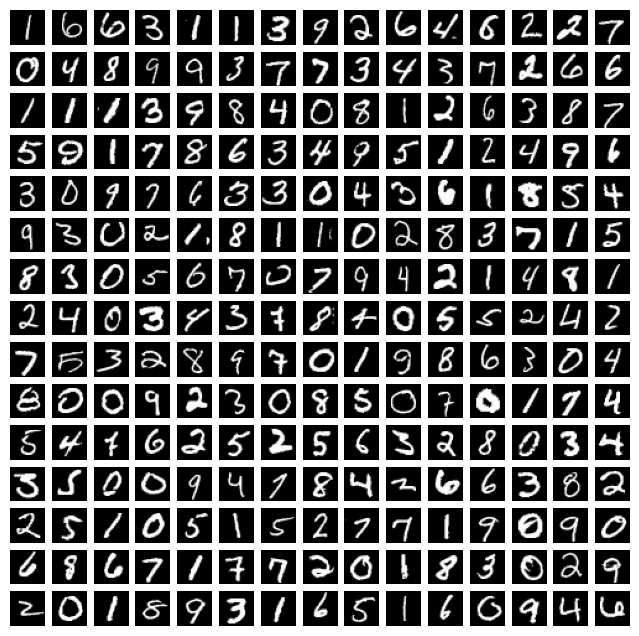

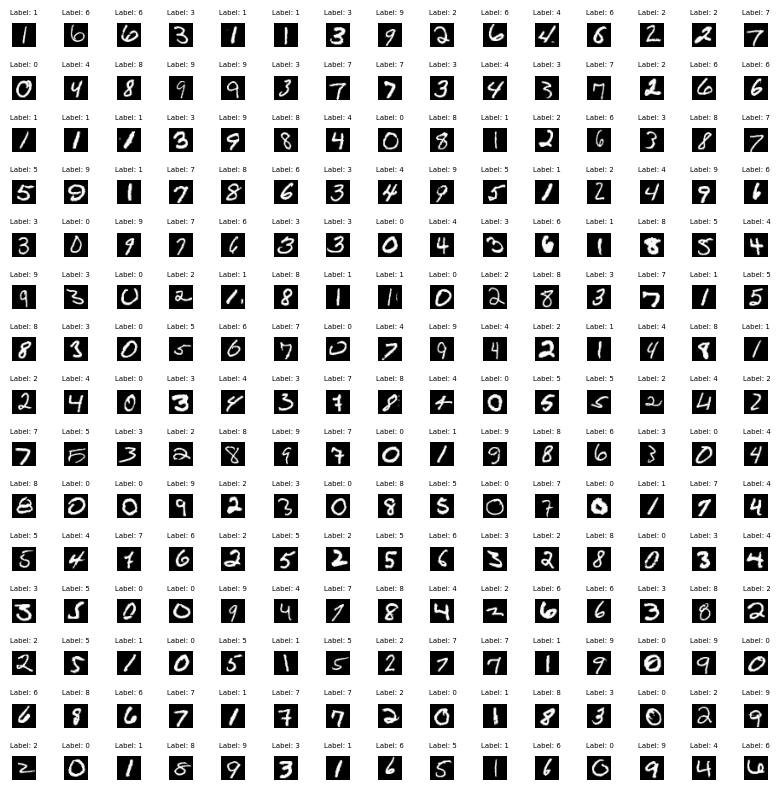

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
a=15
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(mnist_dataset, batch_size=a**2, shuffle=True)
images, labels = next(iter(dataloader))
fig, axes = plt.subplots(a, a, figsize=(8, 8))
axes = axes.flatten()
for i in range(a**2):
  ax = axes[i]
  img = images[i].numpy().squeeze()  # 转换为numpy数组并去除通道维度
  ax.imshow(img, cmap='gray')
  ax.axis('off')

fig, axes = plt.subplots(a, a, figsize=(8, 8))
axes = axes.flatten()

for i in range(a**2):
  ax = axes[i]
  img = images[i].numpy().squeeze()  # 转换为numpy数组并去除通道维度
  ax.imshow(img, cmap='gray')
  ax.set_title(f'Label: {labels[i].item()}',fontsize=5)
  ax.axis('off')

plt.tight_layout()
plt.show()